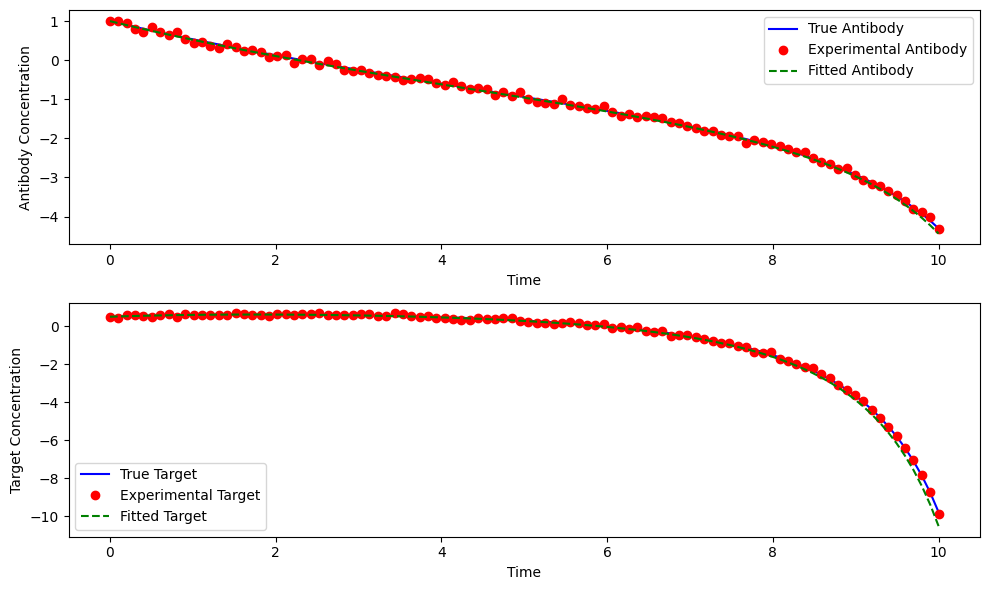

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Function defining the TMDD model equations
def tmdd_model(y, t, CL, kint, kout, kdeg, kon, koff):
    A, T = y

    dAdt = -CL + kint * T - kout * A
    dTdt = -kdeg * T + kon * A - koff * (kon * A * T) / (koff + kdeg)

    return [dAdt, dTdt]

# Function for simulating PK/PD
def simulate_pkpd(CL, kint, kout, kdeg, kon, koff, initial_conditions, time_points):
    params = (CL, kint, kout, kdeg, kon, koff)

    # Solve the differential equations
    solution = odeint(tmdd_model, initial_conditions, time_points, args=params)

    return solution[:, 0], solution[:, 1]

# Function for curve fitting
def fit_pkpd(time_points, antibody_exp, target_exp):
    def fit_func(time, CL, kint, kout, kdeg, kon, koff):
        initial_conditions = [antibody_exp[0], target_exp[0]]
        antibody_sim, target_sim = simulate_pkpd(CL, kint, kout, kdeg, kon, koff, initial_conditions, time)
        return np.concatenate((antibody_sim, target_sim))

    popt, _ = curve_fit(fit_func, time_points, np.concatenate((antibody_exp, target_exp)))
    CL_fit, kint_fit, kout_fit, kdeg_fit, kon_fit, koff_fit = popt

    return CL_fit, kint_fit, kout_fit, kdeg_fit, kon_fit, koff_fit

# Parameters for simulation
CL_true = 0.5   # True clearance rate of the antibody
kint_true = 0.2   # True internalization rate constant
kout_true = 0.1   # True elimination rate constant
kdeg_true = 0.05  # True degradation rate constant
kon_true = 0.3    # True association rate constant between antibody and target
koff_true = 0.2   # True dissociation rate constant between antibody-target complex

initial_conditions = [1.0, 0.5]  # Initial antibody and target concentrations
time_points = np.linspace(0, 10, 100)  # Time points for simulation

# Simulate PK/PD with true parameters
antibody_conc_true, target_conc_true = simulate_pkpd(CL_true, kint_true, kout_true, kdeg_true, kon_true, koff_true, initial_conditions, time_points)

# Generate noisy experimental data
noise_std = 0.05  # Standard deviation of noise
antibody_exp = antibody_conc_true + np.random.normal(0, noise_std, size=time_points.shape)
target_exp = target_conc_true + np.random.normal(0, noise_std, size=time_points.shape)

# Fit the model to experimental data
CL_fit, kint_fit, kout_fit, kdeg_fit, kon_fit, koff_fit = fit_pkpd(time_points, antibody_exp, target_exp)

# Simulate PK/PD with fitted parameters
antibody_conc_fit, target_conc_fit = simulate_pkpd(CL_fit, kint_fit, kout_fit, kdeg_fit, kon_fit, koff_fit, initial_conditions, time_points)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot true and fitted antibody concentrations
plt.subplot(2, 1, 1)
plt.plot(time_points, antibody_conc_true, 'b-', label='True Antibody')
plt.plot(time_points, antibody_exp, 'ro', label='Experimental Antibody')
plt.plot(time_points, antibody_conc_fit, 'g--', label='Fitted Antibody')
plt.xlabel('Time')
plt.ylabel('Antibody Concentration')
plt.legend()

# Plot true and fitted target concentrations
plt.subplot(2, 1, 2)
plt.plot(time_points, target_conc_true, 'b-', label='True Target')
plt.plot(time_points, target_exp, 'ro', label='Experimental Target')
plt.plot(time_points, target_conc_fit, 'g--', label='Fitted Target')
plt.xlabel('Time')
plt.ylabel('Target Concentration')
plt.legend()

plt.tight_layout()
plt.show()
